# Analyzing the topics that are prominent in the distribution of tweets from CNN and FOXNEWS by utilizing NLP and LDA mallet model (Latent Dirichlet Allocation)

Below you will find the list of the imported libraries for being able to use certain functions for desired usage.

In [1]:
import spacy
from gensim.corpora import Dictionary
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
import numpy as np
import pandas as pd
import gensim.models.word2vec

Explanation of library usage

- pandas: this package will be used to be able to read data, visualization of the results and managing data (transforming, adding, removing etc.)
- spacy: this package will be used for pre-processing task such as tokenization, lemmatization, POS tagging (nouns, adj) and cleaning text
- gensim: this package will be used to implement a TOPIC model and evaluation
- numpy: for manupulating arrays


## Phase 1: Train a topic model on the description column in framing.p. Describe and explain your pre-processing steps and parameters.

Within this phase, we will first read in the data. Then, apply pre-processing for desired text format. Furthermore, train multiple topic models with different number of topics and as last, apply evaluation to choose the best topic model.

### Step 1: read data and view the structure to get a idea about the data

In [7]:
# for being able to read framing.p data we have to call the function read_pickle
df_tweets = pd.read_pickle('../data/framing.p')
# for having a quick idea about the data, first few rows, I use the function head()
df_tweets.head()

,tweet_id,date,user,party,state,chamber,tweet,news_mention,url_reference,netloc,title,description,label
0,1325914751495499776,2020-11-09 21:34:45,SenShelby,R,Alabama,Senator,ICYMI – @BusinessInsider declared #Huntsville ...,businessinsider,https://www.businessinsider.com/personal-finan...,www.businessinsider.com,The 10 best US cities to move to if you want t...,The best US cities to move to if you want to s...,
1,1294021087118987264,2020-08-13 21:20:43,SenShelby,R,Alabama,Senator,Great news! Today @mazda_toyota announced an a...,,https://pressroom.toyota.com/mazda-and-toyota-...,pressroom.toyota.com,Mazda and Toyota Further Commitment to U.S. Ma...,"HUNTSVILLE, Ala., (Aug. 13, 2020) – Today, Maz...",
2,1323340848130609156,2020-11-02 19:06:59,DougJones,D,Alabama,Senator,He’s already quitting on the folks of Alabama ...,,https://apnews.com/article/c73f0dfe8008ebaf85e...,apnews.com,"Tuberville, Jones fight for Senate seat in Ala...","GARDENDALE, Ala. (AP) — U.S. Sen. Doug Jones, ...",
3,1323004075831709698,2020-11-01 20:48:46,DougJones,D,Alabama,Senator,I know you guys are getting bombarded with fun...,,https://secure.actblue.com/donate/djfs-close?r...,secure.actblue.com,I just gave!,Join us! Contribute today.,negiotated
4,1322567531320717314,2020-10-31 15:54:06,DougJones,D,Alabama,Senator,"Well looky here folks, his own players don’t t...",,https://slate.com/culture/2020/10/tommy-tuberv...,slate.com,What Tommy Tuberville’s Former Auburn Players ...,"""All I could think is, why?""",


because in this question the focus is the column 'netloc' and 'description' I will subtract it from the main dataframe

In [8]:
# here I separate the columns and use function copy, so I don't influence the origin data
df_copied_tweets = df_tweets.copy()
df_copied_tweets.columns

Index(['tweet_id', 'date', 'user', 'party', 'state', 'chamber', 'tweet',
       'news_mention', 'url_reference', 'netloc', 'title', 'description',
       'label'],
      dtype='object')

### Step 2: pre-processing by using Spacy

For better structural work for NLP and having the desired text format for training topic model we will apply the following:
- Lemma: I will use lemma for comparison of topics/most frequent words purposes because it removes the inflectional endings and keeps the base form of a word
- Noun: to get better indicators of topics within the documents I will work with nouns
- Lowercase: this is commonly used according to paper: 'How we do things with words analyzing text as Social and Cultural'. But this might result in e.g. 'US' been threaded as 'us' which are not the same
- stopword: I have chosen to exclude stopwords because I don't want them to get a high probability within a topic so I can get only the relevant words.

In [9]:
def process_lemma(doc_v, pos=''):
    # a function for extracting lemma, a desired pos tagging and ignoring punctuations
    return [token.lemma_ for token in doc_v if not token.is_punct and token.pos_ == pos and not token.is_stop]

In [10]:
# first we load a nlp model for tokenization process
nlp = spacy.load("en_core_web_sm")

In [11]:
%%time

# lowercase words before performing nlp
description_with_lowercase = df_copied_tweets.description.str.lower()

# number of processors to use for faster processing
n_process = 2
# bigger buffer in the memory for processing more data
batch_size=2000
# the features created by the components ner, parser won't be used (such as Token.ent_type, Token.dep) and therefore can be disabled (also for efficiency)
disable = ["ner", "parser"]

# compute nlp for extracting the tokens
processed_texts = [doc for doc in nlp.pipe(description_with_lowercase, n_process=n_process, batch_size=batch_size, disable=disable)]

CPU times: user 5.95 s, sys: 454 ms, total: 6.41 s
Wall time: 1min 1s


In [12]:
# storing the processed text in the dataframe for later usage (lemma, cleaning text and training topic model)
df_copied_tweets['processed_texts'] = processed_texts

# here I apply the function 'precess_lemma' for getting lemmatized nouns excluding punctuations
df_copied_tweets['lemma'] = df_copied_tweets.processed_texts.apply(lambda doc: process_lemma(doc, 'NOUN'))

### Step 3: Vectorize text and train a Topic model

- Vectorization: transforming to a format which the machine understands
- Training Topic model: a model that will organize the collection of texts according to the discovered themes which I will use to fetch the topics for my analysis and for being able to realize this I will use LDAMallet.

Creating a vectorized text, so it can be used as an input for the LDA model

In [13]:
# minimum document frequency, word has to occur at least in 3 documents for comparison purposes
# by removing the infrequent words I get a more robust pattern and reduced vocabulary size
MIN_DF = 3
# maximum document frequency, the word has to occur in 85% of the document to be included for comparison purposes
MAX_DF = 0.85

# the corpus containing all tokenized doc text
tokenized_texts = df_copied_tweets.lemma

# initiating a Dictionary object for getting the vocabulary
dictionary = Dictionary(tokenized_texts)
# here we apply the parameters
dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
# here we create a term document frequency
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

Training a Topic model

In [ ]:
%%time

PATH_TO_MALLET = '../data/mallet-2.0.8/bin/mallet'

# (number of training iterations) controls how often it repeats a particular loop over each document, higher the better
N_ITERATIONS = 1000

# generate a sequence of numerical values 10, 30 ... 110 for training multiple topic models as purpose to choose a topic model at the end
n_topics = np.arange(10, 120, 20)

# vector for storing the trained topic models for later evaluation
models = []

# loop over n topics
for n_topic in n_topics:
    print(f'Training topics: {n_topic} ....')

#     computing the model
    lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=n_topic,
                optimize_interval=10,
                iterations=N_ITERATIONS)

    # saving the trained lda model
    lda.save(f'../models/lda_{n_topic}_model')

#     storing the model for later evaluation
    models.append(lda)

### Step 4: Choosing the best model for further analysis

For being able to choose the best topic model I will use Topic Coherence. The main reason for using this measurement technique is due to not being able to use the integrated function 'log_perplexity' because it only gives NaN values. But the chosen technique also provides a convenient measure. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [15]:
evaluated_models = []

# loop over all trained models and store the Coherence value of each model for evaluation
for model in models:
    # cast LDA mallet to LDA model for being able to calculate the Coherence
    lda_model = malletmodel2ldamodel(model)
    # store Coherence score of each model for evaluation purposes (choosing desired k topics)
    coh_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    # get coherence value
    coherence_lda = coh_model.get_coherence()
    # store the value in a vector
    evaluated_models.append(coherence_lda)

Model X Coherence Score evaluation


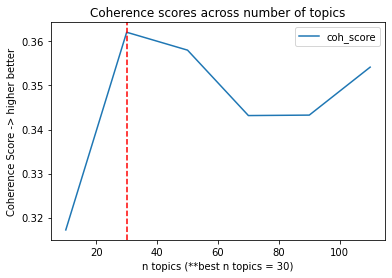

In [16]:
print('Model X Coherence Score evaluation')

# add the scores in a dataframe to plot
df_scores = pd.DataFrame({
    'coh_score': evaluated_models
}, index=n_topics)

# get the max Coherence score
max_score = max(df_scores.coh_score)
# get the index of the max score to draw a vertical line for better readability
index_max_score = df_scores.index[max_score == df_scores.coh_score].tolist()[0]

# plot the scores
ax = df_scores.plot(title= 'Coherence scores across number of topics', xlabel=f'n topics (**best n topics = {index_max_score})', ylabel='Coherence Score -> higher better')
# draw a vertical line on the highest score
ax.axvline(x=index_max_score, color='red', linestyle='--')

To have a quick view of the top 10 words (highest probability) within best topic model

In [19]:
best_n_topics = index_max_score
# to show the top 10 words
MAX_WORDS = 10

# the best model is stored in index 1 of models array
best_lda_model = models[1]

# the words with the highest probability
words = best_lda_model.show_topic(0, topn=MAX_WORDS)

# store the top words in a dataframe
df_top_words = pd.DataFrame(words, columns=['word', 'prop'])
# print the top words
df_top_words


,word,prop
0,medium,0.042012
1,post,0.022941
2,platform,0.022388
3,twitter,0.022112
4,tech,0.020453
5,account,0.018519
6,company,0.017413
7,facebook,0.012991
8,video,0.012438
9,report,0.012161


### Explanation:

Although some steps are already provided with an explanation, I will briefly summarize it here.

Phase 1 is about preparing the data in a fashion to train a topic model. In order to realize this, I first read in the desired data file. Next, to be able to perform proper preprocessing, I use spacy which is equipped with a wide range of features. With that method I first tokenize the desired texts. Then apply lemmatization (to be able to compare topics and to keep the base form), noun (as indicators of topics) and lowercase. The goal of these steps is to improve the ratio of tokens to types. Furthermore, I vectorize the text and create a term document frequency which the machine understands for training purposes. Finally, I train multiple topic models with different n topics within a loop with needed parameters (such as corpus, id2word and iterations) so I can analyse the different n topic models for choosing the best topic model for further analysis.


## Phase 2: Choose two news media from the column netloc that are relevant to compare and explain your choice.

motivation:

I have chosen to compare CNN and FOX-NEWS because CNN is a left-wing and FOX-news right-wing news media, and I'm curious on which topics they will differ or be equal especially during pandemic. Furthermore, I would like to see what topics were important for each media and what those topics mean for each of them.

### Step 1: join the dataframe with the document and his related topic distribution plus the probability of each topic for that document

In [20]:
# topic distribution per document, given the best model based on Top Coherence
transformed_docs = best_lda_model.load_document_topics()
# store the distribution within a DataFrame to be able to join it with the input DataFrame
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs],
             columns=['topic_{}'.format(i) for i in range(best_n_topics)])


In [21]:
# Joining the document x topic distribution with the input DataFrame
joined_topic_dist = df_copied_tweets.reset_index().join(topic_distributions)


### Step 2: select only rows with CNN and FOX-NEWS as netloc

In [22]:
# selects only rows with the 2 netlocs
df_netlocs = joined_topic_dist[joined_topic_dist.netloc.isin(['www.cnn.com', 'www.foxnews.com'])].copy()


In [23]:
# dropping columns which won't be used and for better readability
drop_columns = ['tweet_id', 'user', 'news_mention', 'url_reference', 'label', 'tweet', 'title']
df_netlocs = df_netlocs.drop(drop_columns, axis=1)


### Step 3: compare the topic proportions between those two news media

In [24]:
# group by netloc and calculate the mean of the topics for each netloc
# by using 1: we skip the first index which is index caused by reset_index()
# and then do a tranpose (media X topic) -> (topic X media)
df_netlocs_props = df_netlocs.groupby('netloc').mean().T[1:]


<AxesSubplot:title={'center':'Topic proportion of each news media'}, xlabel='topic id', ylabel='proportion'>

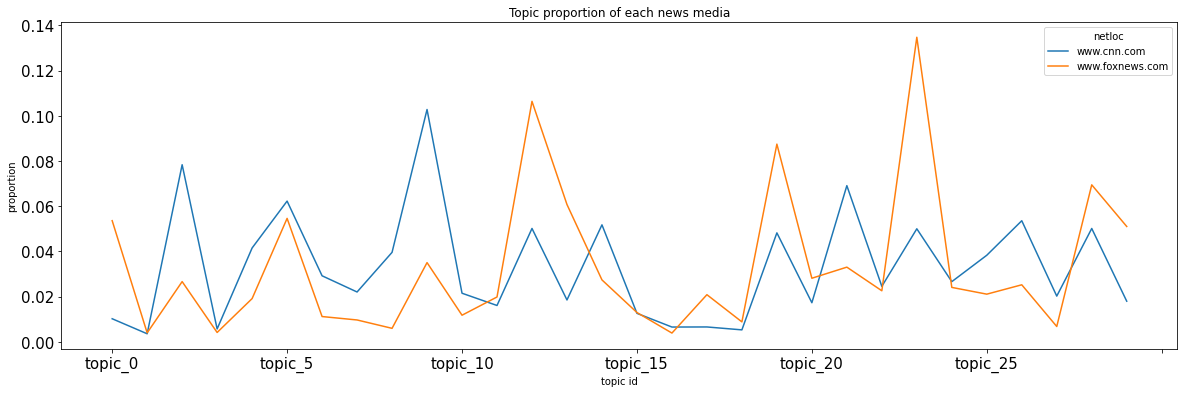

In [25]:
# plots the topic proportion of each news media
df_netlocs_props.plot(title='Topic proportion of each news media', figsize=(20, 6), fontsize=15, xlabel='topic id', ylabel='proportion')


According to the plot, the news media differ and is similar on certain topics looking at the proportion. 
What immediately strikes me is that topic 2, 9 is significantly more prominent in CNN and topic 12, 23 in FOX-NEWS. In addition, both are identical in topic 5.

To get a understanding of the findings I will extract most prominent topics in both news media (as mentioned above) for visualization (wordcloud) purposes.

### Step 4: visualization with WordCloud

In [ ]:
!pip install wordcloud

import matplotlib.pyplot as plt
import requests

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud

Explanation of library usage:

- wordcloud: for being able to plot a cloud of words I will have to install the wordcloud package
- matplotlib: for managing plotting data
- PIL: for transforming bytes into a image
- requests: for fetching data from external source (such as images)

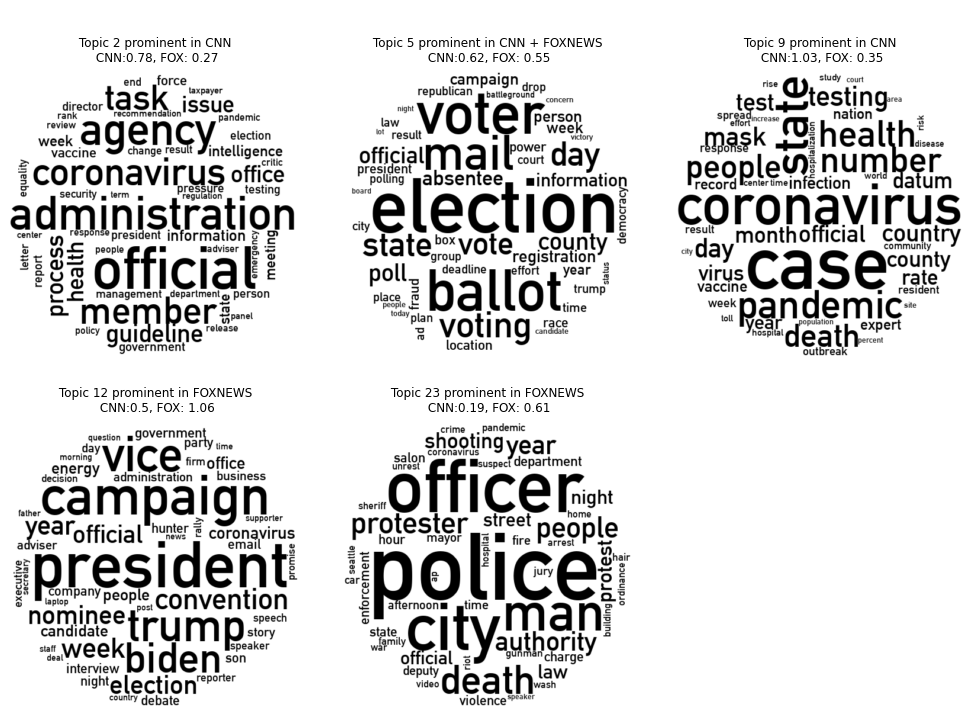

In [142]:
# max words from a topic
MAX_WORDS = 50

# 2d arr for later usage
# the interesting topics
topics_analyze = [[2, 5, 9], [12, 23]]
# the names of the media per interesting topic, so in parallel with the 2d array above
media_names = [['CNN', 'CNN + FOXNEWS', 'CNN'], ['FOXNEWS', 'FOXNEWS']]
proportions = [
    [df_netlocs_props.values[2], df_netlocs_props.values[5], df_netlocs_props.values[9]],
    [df_netlocs_props.values[12], df_netlocs_props.values[13]]
]

# fetches a black circle template
def black_circle():
    response = requests.get('https://i.ibb.co/kHNWRYD/black-circle-better.png')
    circle_mask = np.array(Image.open(BytesIO(response.content)))
    return circle_mask

# returns a wordcloud object
def get_wordcloud():
    circle_mask = black_circle()
    wordcloud = WordCloud(background_color='#fff',
                      font_path='/System/Library/Fonts/Supplemental/DIN Alternate Bold.ttf',
                    color_func=lambda *args, **kwargs: (0,0,0),
                     mask=circle_mask)
    return wordcloud

# declare subplots with 2 by 3
fig, axes = plt.subplots(len(topics_analyze), 3, figsize=(14, 10), tight_layout=True)

# get the wordcloud object
wordcloud = get_wordcloud()

# loop over the topics and names to create for each interesting topic a wordcloud
for row_idx in range(0, len(topics_analyze)):
    for col_idx in range(0, len(topics_analyze[row_idx])):
#         get the n topic
        n_topic = topics_analyze[row_idx][col_idx]
#     get the media name
        media_name = media_names[row_idx][col_idx]
#     get proportion and multiply by 10 to have a clear view of the proportion difference
        proportion = proportions[row_idx][col_idx] * 10
#     get the ax subplot
        ax = axes[row_idx][col_idx]
#     generate wordcloud of words
        wordcloud.generate_from_frequencies(frequencies=dict(best_lda_model.show_topic(n_topic, MAX_WORDS)))
#     add title and show the wordcloud
        ax.axis("off")
        title = f'\n\n Topic {n_topic} prominent in {media_name} \n CNN:{round(proportion[0], 2)}, FOX: {round(proportion[1], 2)}'
        ax.set_title(title)
        ax.imshow(wordcloud, interpolation="bilinear")


# removes the most bottom right corner subplot because I only plot 5 topics
fig.delaxes(axes[1][2])
    

### Interpretation and discussion:

After applying wordcloud for each topic and news media, we get a clear picture of which points within a topic were important for each news media or both.

When comparing topics that are prominent in each news media, we see that CNN (topic 2 and 9) has focused more on the conditions within the context of pandemic, health and human testing. Which attracted a lot of attention worldwide in the year of 2020, because pandemic was a global problem. Furthermore, political topics were also present such as official, agency and administration. In contrast, looking at FOXNEWS (topic 12 and 23) we rarely see information about the pandemic. For them, the events surrounding the 2020 US presidential election between Trump and Biden were more  important. The result also shows that the topics police, death, man and protest were prominent. Which I believe refers to the death of George Floyd and the circumstances surrounding the subject. If we look at topic 5 where both news media have identical proportions we see that they have similar topics such as the US presidential election, voters, the situation around ballots and the discussion around digital or analog voting so by emailing or in person. It seems as if FOXNEWS has rarely talked about the pandemic who leans more towards national politics and CNN about the circumstances surrounding the police and George Floyd's death. Having analysed the results, I would like to know the following: Has the position of FOX NEWS changed, considering the prominent topics police, death and man? From what perspective did they publish articles on these topics? Does the perspective change their political position or remain the same?


### Data set construction:

The dataset consists of tweets in response to articles published by news media in the year 2020. The tweets come from Twitter users who have a preference for a particular political party. Knowing that the dataset is an merge of the dataset of students who had to label, there is of course a chance that a student may have adjusted the column description, which could lead to unexpected results. Therefore, we must thread it as a tool which gives us a insight in the structured information rather than taking it as it is.

### Documents consulted:

- Doi:10.3389/frai.2020.00062 : How We Do Things With Words: Analyzing Text as Social and Cultural Data
- Doi:10.1145/2133806.2133826 : Probabilistic topic models
